# Metropolis-Hastings Algorithm
Metropolis-Hastings works with unnormalized densities $h(x)$. This means that $h(x)$ is a constant times a probability density function.

This is very useful because these sorts of densities often occur in Bayesian statistics - we often end up with a posterior which is $\propto p(x|y) p(y)$, with no way of working out the normalising constant for this distribution. Thus the Metropolis-Hastings algorithm allows us to sample from such densities without having to worry about normalising.

The MH algorithm requires a _proposal distribution_, $q(y|x)$ in addition to the unnormalized density $h(x)$. The proposal distribution is a probability distribution which randomly suggests points $y$ which we should visit, if we are currently at point $x$. 

The other component is the _Hastings Ratio_:

$$
r(x, y) = \frac{h(y) q(y|x)}{h(x) q(x|y)}
$$

The steps of the algorithm are:

1. Sample a new point from the proposal distribution.
2. Calculate the Hastings ratio
3. Calculate $a(x, y) = \min(1, r(x, y))$. Then move to point $y$ with probability $a(x,y)$ (otherwise stay at $x$).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext Cython
%load_ext line_profiler

In [2]:
def mh_mcmc(x_0, h, q, proposal, n, with_stats=False):
    x_0 = np.asarray(x_0)
    x = x_0
    chain = np.empty((n, x_0.shape[0]))
    chain[0, :] = x_0
    acceptances = 0
    
    proposals=0
    while True:
        proposals+=1
        y = proposal(x)
        r = h(y) * q(y, x) / (h(x) * q(x, y)) # metropolis-hastings update
        #r = h(y) / h(x) # metropolis update
        #print y, r, h(y), h(x)
        a = min(1, r)
        if np.random.uniform() < a:
            chain[acceptances] = y
            x = y
            acceptances+=1
            if acceptances == n: break
    if not with_stats:
        return chain
    
    return chain, {'proposals': proposals}

In [3]:
h = lambda x: np.exp(-(x)**2 / 2.)
def proposal_proba(x, y, sigma):
    sigma2 = sigma ** 2
    exponent = -np.sum((x - y)**2) / (2. * sigma2)
    return np.exp(exponent) / (2. * sigma2)**(x.shape[0] / 2.)

sigma = 0.2
q = lambda x,y: proposal_proba(x, y, sigma)
q_sampler = lambda x: np.random.normal(x, sigma, x.shape)

In [4]:
x_0 = np.array([2.])

In [5]:
%%time
_=mh_mcmc(x_0, h, q, q_sampler, 1000)

CPU times: user 50.4 ms, sys: 1.53 ms, total: 52 ms
Wall time: 59.9 ms


In [6]:
sample_size=10000
samp, samp_stats = mh_mcmc([2], h, q, q_sampler, sample_size, True)


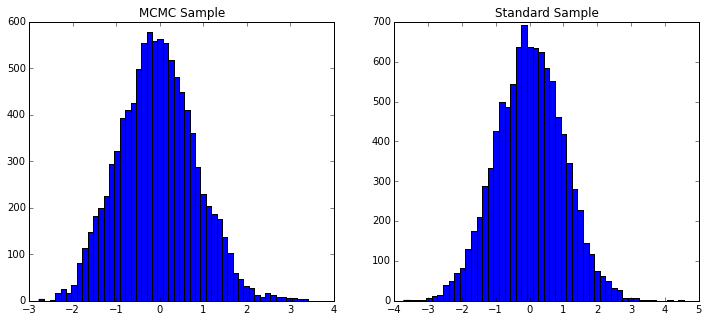

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('MCMC Sample')
plt.hist(samp, 50)
plt.subplot(122)
plt.title('Standard Sample')
plt.hist(np.random.normal(size=sample_size), 50);

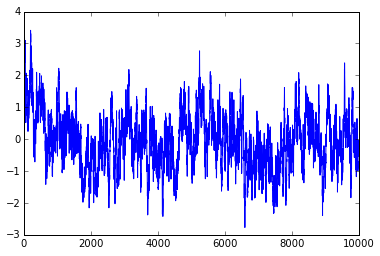

In [8]:
plt.plot(np.arange(samp.size), samp)

In [9]:
#%lprun -f mh_mcmc mh_mcmc([2], h, q, q_sampler, 100, True)